In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Embedding, LSTM, Input,SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop, Adadelta

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model

import yaml

In [ ]:
from google.colab import drive  #connect the Google drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data loading and processing

In [ ]:
!wget http://www.manythings.org/anki/rus-eng.zip  #скачиваем dataset

--2022-03-15 13:44:45--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.186.54, 104.21.92.44, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.186.54|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14683939 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.00M  48.6MB/s    in 0.3s    

2022-03-15 13:44:45 (48.6 MB/s) - ‘rus-eng.zip’ saved [14683939/14683939]



In [ ]:
!ls  #проверям список файлов

drive  rus-eng.zip  sample_data


In [ ]:
!unzip -o rus-eng.zip #распаковка архива

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [ ]:

with open('rus.txt', 'r', encoding='utf-8') as f:
  lines=f.read().split('\n') #разибваем файл на строки

In [ ]:
len(lines)

440220

In [ ]:
lines[0]

'Go.\tМарш!\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)'

In [ ]:
def extract_texts(begin_index=0, qty=50000):
  conversations=[]
  
  lenLines=len(lines)
  #if begin_index is beyond of lines number
  if begin_index>=lenLines:
    return None
  #calculation of end_index
  end_index=begin_index+qty
  if end_index >= lenLines:
    end_index = lenLines         #if end_index is beyond of lines number

  for i in range(begin_index,end_index):
    try:
      eng_text, rus_text,_ = lines[i].split('\t') #разделяем линии на русские и англ сообщения
      conversations.append([eng_text,rus_text])
    except:
      continue

  return conversations 

In [ ]:
conversations=extract_texts(qty=100000)

In [ ]:
len(conversations)

100000

In [ ]:
#функция для удаления пробелов перед знаками препинания
def replacer(inputs):
  
  if isinstance(inputs,str):
      return inputs.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')

  if isinstance(inputs, list):
    outputs=[]

    for line in inputs:
      outputs.append(line.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?'))

    return outputs

In [ ]:
#списки для переводчика eng-rus
eng_questions=[] 
rus_answers=[]

#списки для переводчика rus-eng
rus_questions=[] 
eng_answers=[]

for con in conversations:
  if len(con)>1:
    eng=replacer(con[0]) #чистим англю предложения
    eng_questions.append(eng)
    eng_answers.append(eng)

    rus=replacer(con[1:]) #чистим русские предложения
    rus=' '.join(rus)
    rus_questions.append(rus)
    rus_answers.append(rus)

  else:
    continue

#добавляем тэги к ответам  
eng_answers=['<START> ' + answ + ' <END>' for answ in eng_answers]  
rus_answers=['<START> ' + answ + ' <END>' for answ in rus_answers]


In [ ]:
#Создадим токенайзер
tokenizer=Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')

#обучение токенайзера
tokenizer.fit_on_texts(eng_questions+rus_answers)

vocabularyItems=list(tokenizer.word_index.items())
vocabularySize=len(vocabularyItems)+1

print('Фрагмент словаря : {}'.format(vocabularyItems[:30]))
print('Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('я', 3), ('i', 4), ('tom', 5), ('не', 6), ('том', 7), ('you', 8), ('это', 9), ('is', 10), ('a', 11), ('ты', 12), ('to', 13), ('the', 14), ('вы', 15), ("i'm", 16), ('мне', 17), ('мы', 18), ('do', 19), ('it', 20), ('was', 21), ('у', 22), ('we', 23), ('в', 24), ('что', 25), ("don't", 26), ('он', 27), ('my', 28), ('are', 29), ('your', 30)]
Размер словаря : 41881


In [ ]:
#Fuction makes tokens sequence from phrase
def strToTokens(sentence, maxLen):
  #clear extra spaces
  tmp_sent=replacer(sentence)

  #convert the sentece to lower case and divide to words
  words=tmp_sent.lower().split()

  #list for tokens
  tokensList=list()

  for word in words:

    try:
      tokensList.append(tokenizer.word_index[word]) #try to get a token for a word
    
    except:
      pass  #or just ignore that word

  #if length >0
  if tokensList:
      return pad_sequences([tokensList],maxlen=maxLen, padding='post') #return a padded sequence
  
  # or return None 
  return None

#Preparing ENG-RUS data

In [ ]:
#transform input date to tokens sequences
tokenQuestEng=tokenizer.texts_to_sequences(eng_questions)

#get max length
maxLenQuestEng=max([len(x) for x in tokenQuestEng])

#make the sequences have equal length via padding with zeros
paddedQuestEng=pad_sequences(tokenQuestEng, maxlen=maxLenQuestEng, padding='post')

#to np.array
encEngInput=np.array(paddedQuestEng)

ind=1111 #index of example
print("Input phrase example               : {} ".format(eng_questions[ind]))
print('Input coded phrase example         : {} '.format(encEngInput[ind]))
print('Shape of coded input array         : {} '.format(encEngInput.shape))
print('Established length of input phrase : {} '.format(maxLenQuestEng))

Input phrase example               : Head east. 
Input coded phrase example         : [1982 7518    0    0    0    0    0] 
Shape of coded input array         : (100000, 7) 
Established length of input phrase : 7 


training data prepocessing for decoder input

In [ ]:
tokenAnsRus=tokenizer.texts_to_sequences(rus_answers)
maxLenAnsRus=max([len(x) for x in tokenAnsRus])

paddedAnsRus=pad_sequences(tokenAnsRus, maxlen=maxLenAnsRus, padding='post')

decRusInput=np.array(paddedAnsRus)

ind=1111 #index of example
print("Decoder input phrase example                   : {} ".format(rus_answers[ind]))
print('Decoder input coded phrase example             : {} '.format(decRusInput[ind]))
print('Shape of coded input array for decoder         : {} '.format(decRusInput.shape))
print('Established length of input phrase for decoder : {} '.format(maxLenAnsRus))

Decoder input phrase example                   : <START> Направляйтесь на восток. <END> 
Decoder input coded phrase example             : [    1 12131    38  7867     2     0     0     0     0     0     0     0
     0] 
Shape of coded input array for decoder         : (100000, 13) 
Established length of input phrase for decoder : 13 


Validation data preprocessing for decoder output (these data are equal to data above, except deleted //'START' tag 

In [ ]:
for i in range(len(tokenAnsRus)):  #remove the <START> tag
  tokenAnsRus[i]=tokenAnsRus[i][1:]

#make actions which are equal to action in previous code block

#emphasise that we use max length  of phrase from previous block to train the model properly 
paddedAnsRus=pad_sequences(tokenAnsRus, maxlen=maxLenAnsRus, padding='post')  

decRusOutput=np.array(paddedAnsRus)

ind=1111 #index of example
print("Decoder output phrase example                   : {} ".format(rus_answers[ind]))
print('Decoder output coded phrase example             : {} '.format(decRusOutput[ind]))
print('Shape of coded output array for decoder         : {} '.format(decRusOutput.shape))


Decoder output phrase example                   : <START> Направляйтесь на восток. <END> 
Decoder output coded phrase example             : [12131    38  7867     2     0     0     0     0     0     0     0     0
     0] 
Shape of coded output array for decoder         : (100000, 13) 


#Preparing RUS-ENG data

In [ ]:
#transform input date to tokens sequences
tokenQuestRus=tokenizer.texts_to_sequences(rus_questions)

#get max length
maxLenQuestRus=max([len(x) for x in tokenQuestRus])

#make the sequences have equal length via padding with zeros
paddedQuestRus=pad_sequences(tokenQuestRus, maxlen=maxLenQuestRus, padding='post')

#to np.array
encRusInput=np.array(paddedQuestRus)

ind=1111 #index of example
print("Input phrase example               : {} ".format(rus_questions[ind]))
print('Input coded phrase example         : {} '.format(encRusInput[ind]))
print('Shape of coded input array         : {} '.format(encRusInput.shape))
print('Established length of input phrase : {} '.format(maxLenQuestRus))

Input phrase example               : Направляйтесь на восток. 
Input coded phrase example         : [12131    38  7867     0     0     0     0     0     0     0     0] 
Shape of coded input array         : (100000, 11) 
Established length of input phrase : 11 


In [ ]:
tokenAnsEng=tokenizer.texts_to_sequences(eng_answers)
maxLenAnsEng=max([len(x) for x in tokenAnsEng])

paddedAnsEng=pad_sequences(tokenAnsEng, maxlen=maxLenAnsEng, padding='post')

decEngInput=np.array(paddedAnsEng)

ind=1111 #index of example
print("Decoder input phrase example                   : {} ".format(eng_answers[ind]))
print('Decoder input coded phrase example             : {} '.format(decEngInput[ind]))
print('Shape of coded input array for decoder         : {} '.format(decEngInput.shape))
print('Established length of input phrase for decoder : {} '.format(maxLenAnsEng))

Decoder input phrase example                   : <START> Head east. <END> 
Decoder input coded phrase example             : [   1 1982 7518    2    0    0    0    0    0] 
Shape of coded input array for decoder         : (100000, 9) 
Established length of input phrase for decoder : 9 


In [ ]:
for i in range(len(tokenAnsEng)):  #remove the <START> tag
  tokenAnsEng[i]=tokenAnsEng[i][1:]

#make actions which are equal to action in previous code block

#emphasise that we use max length  of phrase from previous block to train the model properly 
paddedAnsEng=pad_sequences(tokenAnsEng, maxlen=maxLenAnsEng, padding='post')  

decEngOutput=np.array(paddedAnsEng)

ind=1111 #index of example
print("Decoder output phrase example                   : {} ".format(eng_answers[ind]))
print('Decoder output coded phrase example             : {} '.format(decEngOutput[ind]))
print('Shape of coded output array for decoder         : {} '.format(decEngOutput.shape))

Decoder output phrase example                   : <START> Head east. <END> 
Decoder output coded phrase example             : [1982 7518    2    0    0    0    0    0    0] 
Shape of coded output array for decoder         : (100000, 9) 


# The Model Class

In [ ]:
class Translator():
  def __init__(self, maxLenInput,maxLenOutput, drop_rate=0.2):
    self.num_units=400                # number of neurons
    self.maxLenInput=maxLenInput      #maximum length of input sentence
    self.maxLenOutput=maxLenOutput    #maximum length of output sentence
    self.drop_rate=drop_rate          #dropout rate

    self.__makeEncoder()    #create the encoder
    self.__makeDecoder()    #create the decoder
    
    self.modelTrain=Model([self.encInput,self.decInput],self.output)  #create the model
    self.modelTrain.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy') #compile the model 
    
  #encoder architecture
  def __makeEncoder(self):
    self.encInput=Input(shape=(None,))                                           #input layer
    encEmb=Embedding(vocabularySize,self.num_units, mask_zero=True) (self.encInput)    #embedding layer
    drop=SpatialDropout1D(self.drop_rate) (encEmb)
    outputs, state_h, state_c=LSTM(self.num_units, return_state=True) (drop)         #LSTM with its states

    self.encStates=[state_h, state_c]                                            #encoder states

  #decoder architecture
  def __makeDecoder(self):

    #some layers for decoder
    self.decLSTM=LSTM(self.num_units, return_state=True, return_sequences=True)            #LSTM layer with sequences and states
    self.decDense=Dense(vocabularySize,activation='softmax')                    #Dense with softmax activation

    self.decInput=Input(shape=(None,))                                          #input layer
    self.decEmb=Embedding(vocabularySize,self.num_units, mask_zero=True) (self.decInput)   #embedding
    drop=SpatialDropout1D(self.drop_rate) (self.decEmb)
    decoderOutputs, _, _ =self.decLSTM(drop,initial_state=self.encStates) #LSTM outputs
    self.output=self.decDense(decoderOutputs)


  #train function 
  def train(self,xDataInput,yDataInput,batch_size=256,epochs=30,initial_epoch=0, val_split=0.1, random_seed=33 ):
    
    #copy data to independent shuffle
    xData1=np.copy(xDataInput[0])
    xData2=np.copy(xDataInput[1])
    yData=np.copy(yDataInput)
    #shuffle with certain seed
    np.random.seed(random_seed)
    np.random.shuffle(xData1)
    np.random.seed(random_seed)
    np.random.shuffle(xData2)
    np.random.seed(random_seed)
    np.random.shuffle(yData)
    
    history=self.modelTrain.fit([xData1,xData2],yData,batch_size=batch_size,epochs=epochs+initial_epoch,initial_epoch=initial_epoch,validation_split=val_split)

    return history.history  #return the history


  #method to making inference model
  def makeInferenceModel(self):

    self.encInfer=Model(self.encInput, self.encStates)

    decStateInput_h=Input(shape=(self.num_units,)) #Input for state_h
    decStateInput_c=Input(shape=(self.num_units,)) #Input for state_c

    decStatesInputs=[decStateInput_h, decStateInput_c] #combine inputs

    #get the output from decoder
    decOut, state_h, state_c=self.decLSTM(self.decEmb, initial_state=decStatesInputs)

    #combine states
    decStates=[state_h,state_c]

    #fed Dense layer 
    decOut=self.decDense(decOut)

    self.decInf=Model([self.decInput]+decStatesInputs,[decOut]+decStates)
  

  #Translation of sentence
  def translate(self,inputs):
    
    in_tokens=strToTokens(inputs,self.maxLenInput) #get tokens from input sentence

    if in_tokens is None: #if network don't know every word from input
      return 'None'

    oneTargetToken=np.zeros((1,1))  #one token to feed the decoder
    oneTargetToken[0,0]=tokenizer.word_index['start'] #firstly it's tag "start"

    stopCondition=False

    outputs=''  #decoded translation

    statesValues=self.encInfer(in_tokens) #get the encoder station

    while not stopCondition:
      
      #make prediction
      decOut, h, c=self.decInf.predict([oneTargetToken]+statesValues)

      #get the token of predicted word
      sampledWordInd=np.argmax(decOut[0,0,:])

      sampledWord = None #variable for word in natural language

      #find the target token
      for word, index in tokenizer.word_index.items():
        if sampledWordInd==index:
            outputs+=' {}'.format(word)
            sampledWord=word

      #tag "end" was generated or length is more than maximum length
      if sampledWord=='end' or len(outputs.split(" "))>self.maxLenOutput:
          stopCondition=True
          if sampledWord=='end': #tag 'end' was gotten
            outputs=outputs[:-3] #delete the tag

      oneTargetToken[0,0]=sampledWordInd #update the token to feed

      statesValues=[h,c] #update the states values
    
    outputs=outputs[1:] #delete the first " "

    if outputs[-1]==" ": #delete the last " ", if it exists
      outputs=outputs[:-1]

    return outputs

  #saving and loading weights
  def saveWeights(self,path):
    self.modelTrain.save_weights(path)

  def loadWeights(self,path):
    self.modelTrain.load_weights(path)






#Training

##ENG-RUS translator

In [ ]:
EngRusTranslator=Translator(maxLenQuestEng,maxLenAnsRus, drop_rate=0.4) #creating the ENG-RUS translator

In [ ]:
#fitting the model
history=EngRusTranslator.train([encEngInput,decRusInput],decRusOutput,epochs=100)

Epoch 1/100
352/352 [==============================] - 115s 301ms/step - loss: 1.7962 - val_loss: 1.5058
Epoch 2/100
352/352 [==============================] - 103s 292ms/step - loss: 1.3672 - val_loss: 1.2940
Epoch 3/100
352/352 [==============================] - 103s 292ms/step - loss: 1.1795 - val_loss: 1.1528
Epoch 4/100
352/352 [==============================] - 103s 292ms/step - loss: 1.0474 - val_loss: 1.0552
Epoch 5/100
352/352 [==============================] - 103s 292ms/step - loss: 0.9482 - val_loss: 0.9878
Epoch 6/100
352/352 [==============================] - 103s 292ms/step - loss: 0.8759 - val_loss: 0.9407
Epoch 7/100
352/352 [==============================] - 103s 292ms/step - loss: 0.8193 - val_loss: 0.9036
Epoch 8/100
352/352 [==============================] - 103s 292ms/step - loss: 0.7701 - val_loss: 0.8754
Epoch 9/100
352/352 [==============================] - 103s 292ms/step - loss: 0.7311 - val_loss: 0.8575
Epoch 10/100
352/352 [==============================] -

KeyboardInterrupt: ignored

Stop the training process due to overfitting

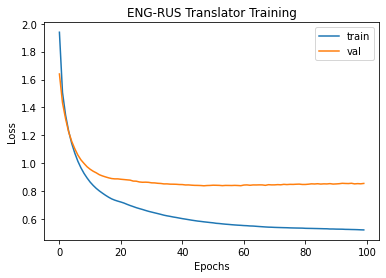

In [ ]:
#plot the chart of loss-function
plt.plot(history['loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ENG-RUS Translator Training')
plt.legend()
plt.show()

In [ ]:
EngRusTranslator.makeInferenceModel() #creating the inference model

In [ ]:
EngRusTranslator.saveWeights('/content/drive/MyDrive/PostUAI/advancedSeq2Seq/EngRusDrop04U400.h5')

In [ ]:
EngRusTranslator.loadWeights('/content/drive/MyDrive/PostUAI/advancedSeq2Seq/EngRusDrop04U400.h5')

In [ ]:
EngRusTranslator.translate('What are you doing?') #translation example 

'что вы делаете?'

In [ ]:
EngRusTranslator.translate('Hello, my friend.') #translation example 

'позволь мне мою руку.'

In [ ]:
EngRusTranslator.translate("I'm glad to see you.") #translation example 

'рада тебя видеть.'

In [ ]:
EngRusTranslator.translate("My car does not work.") #translation example 

'у меня машина не работу.'

In [ ]:
EngRusTranslator.translate("I'm tired.") #translation example 

'я устала.'

In [ ]:
EngRusTranslator.translate("What is your name?.") #translation example 

'что это вас в своей лестнице.'

##RUS-ENG Translator

In [ ]:
RusEngTranslator=Translator(maxLenQuestRus,maxLenAnsEng, drop_rate=0.4) #creating the ENG-RUS translator

In [ ]:

#fitting the model
history=RusEngTranslator.train([encRusInput,decEngInput],decEngOutput,epochs=100)

Epoch 1/100
352/352 [==============================] - 98s 239ms/step - loss: 2.4199 - val_loss: 1.9181
Epoch 2/100
352/352 [==============================] - 81s 231ms/step - loss: 1.6938 - val_loss: 1.5271
Epoch 3/100
352/352 [==============================] - 83s 235ms/step - loss: 1.3870 - val_loss: 1.3109
Epoch 4/100
352/352 [==============================] - 81s 230ms/step - loss: 1.1820 - val_loss: 1.1578
Epoch 5/100
352/352 [==============================] - 81s 231ms/step - loss: 1.0244 - val_loss: 1.0531
Epoch 6/100
352/352 [==============================] - 81s 230ms/step - loss: 0.9017 - val_loss: 0.9677
Epoch 7/100
352/352 [==============================] - 80s 229ms/step - loss: 0.8048 - val_loss: 0.8994
Epoch 8/100
352/352 [==============================] - 81s 230ms/step - loss: 0.7246 - val_loss: 0.8562
Epoch 9/100
352/352 [==============================] - 81s 231ms/step - loss: 0.6587 - val_loss: 0.8141
Epoch 10/100
352/352 [==============================] - 81s 230m

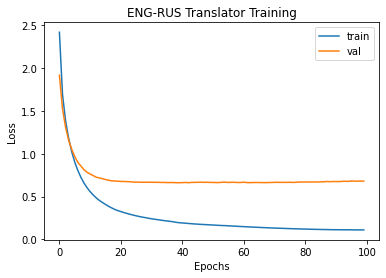

In [ ]:
#plot the chart of loss-function
plt.plot(history['loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ENG-RUS Translator Training')
plt.legend()
plt.show()

In [ ]:
RusEngTranslator.makeInferenceModel() #creating the inference model

In [ ]:
RusEngTranslator.saveWeights('/content/drive/MyDrive/PostUAI/advancedSeq2Seq/RusEngDrop04U400.h5.h5')

In [ ]:
RusEngTranslator.loadWeights('/content/drive/MyDrive/PostUAI/advancedSeq2Seq/RusEngDrop04U400.h5.h5')

In [ ]:
RusEngTranslator.translate('Как твои дела?') #translation example 

'how are you?'

In [ ]:
RusEngTranslator.translate('Я рад видеть тебя.') #translation example 

"i'm glad to see you."

In [ ]:
RusEngTranslator.translate('Моя машина не работает.') #translation example 

"my car isn't working."

In [ ]:
RusEngTranslator.translate('Я устал.') #translation example 

'i got tired.'

In [ ]:
RusEngTranslator.translate('Как тебя зовут?') #translation example 

'what was your name?'

#Double Translation

##ENG-RUS -> RUS-ENG

In [ ]:
def EngRus_RusEng(eng_init):
  rus=EngRusTranslator.translate(eng_init)
  eng=RusEngTranslator.translate(rus)

  print('Original english sentence: ', eng_init)
  print('Translated russian sentence: ', rus)
  print('Double translated english sentence: ', eng)

In [ ]:
EngRus_RusEng("How much is it?")

Original english sentence:  How much is it?
Translated russian sentence:  сколько это стоит?
Double translated english sentence:  how much is it?


In [ ]:
EngRus_RusEng("Do you speak English?")

Original english sentence:  Do you speak English?
Translated russian sentence:  вы говорите по тебе понравился.
Double translated english sentence:  you really missed you.


In [ ]:
EngRus_RusEng("I'm tired.")

Original english sentence:  I'm tired.
Translated russian sentence:  я устала.
Double translated english sentence:  i'm tired.


In [ ]:
EngRus_RusEng("It's rainy today.")

Original english sentence:  It's rainy today.
Translated russian sentence:  сегодня нет там.
Double translated english sentence:  it's not there.


##RUS-ENG -> ENG-RUS 

In [ ]:
def RusEng_EngRus(rus_init):
  eng=RusEngTranslator.translate(rus_init)
  rus=EngRusTranslator.translate(eng)

  print('Original russian sentence: ', rus_init)
  print('Translated english sentence: ', eng)
  print('Double translated russian sentence: ', rus)

In [ ]:
RusEng_EngRus("Лондон - это столица Великобритании.")

Original russian sentence:  Лондон - это столица Великобритании.
Translated english sentence:  this is it?
Double translated russian sentence:  вот и всё.


In [ ]:
RusEng_EngRus("Это все на сегодня.")

Original russian sentence:  Это все на сегодня.
Translated english sentence:  that's all for today.
Double translated russian sentence:  на сегодня всё.


In [ ]:
RusEng_EngRus("Сколько вам лет?")

Original russian sentence:  Сколько вам лет?
Translated english sentence:  how old are you?
Double translated russian sentence:  сколько вам лет?


In [ ]:
RusEng_EngRus("Вам помочь?")

Original russian sentence:  Вам помочь?
Translated english sentence:  shall i help you?
Double translated russian sentence:  тебе помочь?


In [ ]:
RusEng_EngRus("Как пройти в библиотеку?")

Original russian sentence:  Как пройти в библиотеку?
Translated english sentence:  how was paid in a lot.
Double translated russian sentence:  как прошла в школе была позвоните мне.
